In [1]:
import numpy as np
from signal_io.base import Signal

# Fake ECG data: 2 channels, 5000 samples, sampled at 500 Hz
data = np.random.randn(2, 5000)

ecg_signal = Signal(
    data=data,
    sampling_rate=500,
    metadata={"patient_id": "123", "lead": "II"}
)

ecg_signal.summary()
print(f"Duration: {ecg_signal.duration:.2f} seconds")  # → 10.00 seconds

# Make a modified copy without affecting original
filtered = ecg_signal.copy()
filtered.data = np.abs(filtered.data)  # e.g., rectification

Signal Summary
----------------------------------------
Sampling Rate : 500 Hz
Channels      : 2
Samples       : 5,000
Duration      : 10.000 seconds
Metadata      : {'patient_id': '123', 'lead': 'II'}
Duration: 10.00 seconds


In [3]:
from signal_io.audio import load_audio, ensure_mono, resample

# Load a stereo music file at native rate
music = load_audio("C:\\Users\\dipti\\Downloads\\wake-up-call-111748.mp3", mono=False)

print(music.channels)        
print(music.sr)              

# Later decide you need 16kHz mono for a speech model
mono_16k = ensure_mono(music)
final = resample(mono_16k, target_sr=16000)

final.summary()
# You'll see conversion history in metadata

2
48000
Signal Summary
----------------------------------------
Sampling Rate : 16000 Hz
Channels      : 1
Samples       : 1,136,640
Duration      : 71.040 seconds
Metadata      : {'source_file': 'C:\\Users\\dipti\\Downloads\\wake-up-call-111748.mp3', 'domain': 'audio', 'original_sr': 48000, 'conversion': ['to_mono_by_averaging', 'resampled_48000_to_16000Hz']}


Original signal:
Signal Summary
----------------------------------------
Sampling Rate : 500 Hz
Signal Type   : ecg
Channels      : 1
Samples       : 5,000
Duration      : 10.000 seconds
Metadata      : {'patient_id': '001', 'domain': 'ecg', 'description': 'synthetic'}


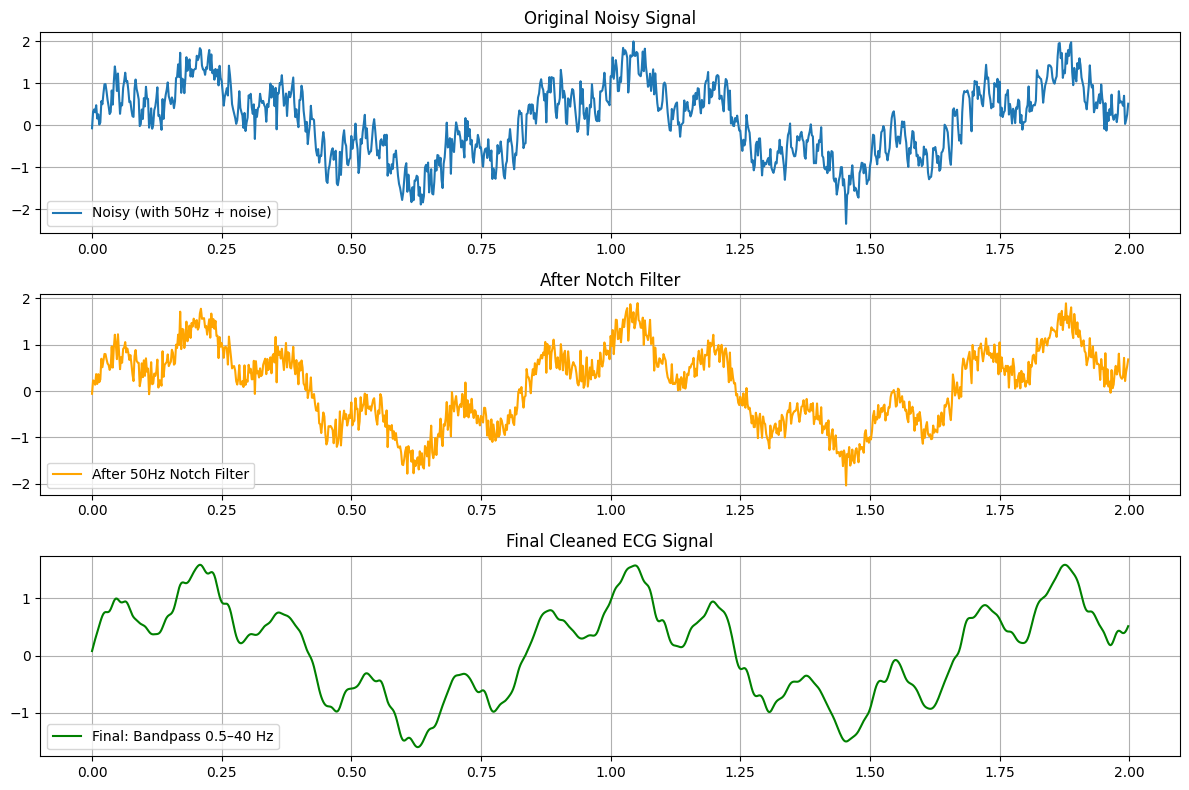


Final signal metadata:
{'patient_id': '001', 'domain': 'ecg', 'description': 'synthetic', 'filter': 'butterworth_bandpass'}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from signal_io.base import Signal
from dsp.filters import butterworth_filter, notch_filter

# -------------------------------
# 1. Create a synthetic ECG-like signal with noise
# -------------------------------
fs = 500  # Sampling rate in Hz
t = np.linspace(0, 10, 10 * fs, endpoint=False)  # 10 seconds

# Clean ECG-like signal (simplified heartbeat pattern)
clean_ecg = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.sin(2 * np.pi * 6 * t)

# Add power line interference (50 Hz in India)
noise_50hz = 0.3 * np.sin(2 * np.pi * 50 * t)

# Add some random noise
noise_random = 0.2 * np.random.randn(len(t))

# Final noisy signal
noisy_ecg = clean_ecg + noise_50hz + noise_random

# Wrap into Signal object
ecg_signal = Signal(
    data=noisy_ecg,
    sampling_rate=fs,
    signal_type="ecg",
    metadata={"patient_id": "001", "domain": "ecg", "description": "synthetic"}
)

print("Original signal:")
ecg_signal.summary()

# -------------------------------
# 2. Apply filters
# -------------------------------

# Remove 50 Hz power line noise
ecg_notch = notch_filter(ecg_signal, notch_freq=50.0, quality_factor=30)

# Apply bandpass filter typical for ECG: 0.5–40 Hz
ecg_filtered = butterworth_filter(
    ecg_notch,
    filter_type="bandpass",
    low_freq=0.5,
    high_freq=40,
    order=4
)

# -------------------------------
# 3. Visualize results
# -------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t[:1000], ecg_signal.data[:1000], label="Noisy (with 50Hz + noise)")
plt.title("Original Noisy Signal")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t[:1000], ecg_notch.data[:1000], label="After 50Hz Notch Filter", color="orange")
plt.title("After Notch Filter")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t[:1000], ecg_filtered.data[:1000], label="Final: Bandpass 0.5–40 Hz", color="green")
plt.title("Final Cleaned ECG Signal")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print metadata to see filter history
print("\nFinal signal metadata:")
print(ecg_filtered.metadata)